In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
import random

In [464]:
from utils.data import Data

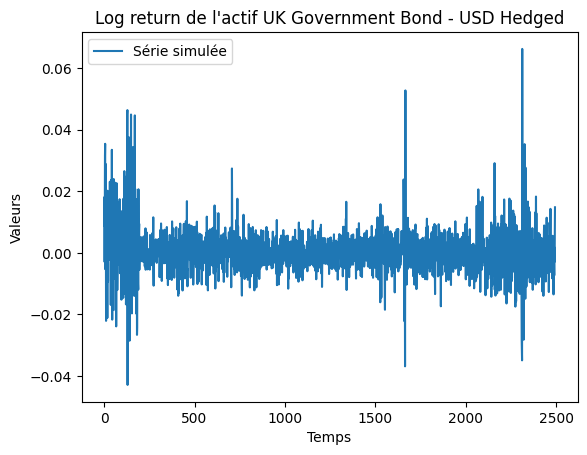

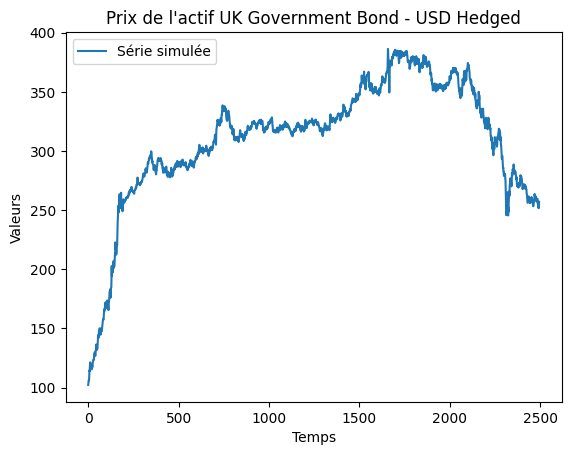

stock


In [350]:
data_set = "stock"
if data_set == "apple":
    df_apple =pd.read_csv('./data/AAPL.csv')
    sdf = df_apple['Adj Close']
    y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
    true_y = df_apple['Adj Close'].to_numpy()
    simple_plot(y[:], f"Log return de l'action Apple")
    simple_plot(true_y[:], f"Prix de l'action Apple")
elif data_set == "IBM":
    start_date = '1950-01-01'
    end_date = '2021-07-12'
    # Define the ticker list
    tickers_list = ['AAPL', 'IBM', 'MSFT', 'WMT']
    # Create placeholder for data
    data = pd.DataFrame(columns=tickers_list)
    # Fetch the data
    for ticker in tickers_list:
        data[ticker] = yf.download(ticker, 
                                start_date,
                                end_date)['Adj Close']

    sdf = data['IBM']
    y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
    true_y = data['IBM'].to_numpy()
    simple_plot(y[:], f"Log return de l'action Apple")
    simple_plot(true_y[:], f"Prix de l'action Apple")
elif data_set == "stock":
    df = pd.read_csv('./data/GANData.csv')
    actif = "UK Government Bond - USD Hedged"
    sdf = df[df['ASSETNAME']==actif]['PRICE']
    y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
    true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
    simple_plot(y[:], f"Log return de l'actif {actif}")
    simple_plot(true_y[:], f"Prix de l'actif {actif}")
print(data_set)

In [351]:
from utils.network import *

In [352]:
import torch
import torch.nn as nn

# On définit un générateur de GAN "basique"
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, ts_dim-condition),
            #nn.Tanh() 
        )

    def forward(self, x):
        return self.model(x)

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Pour obtenir une probabilité entre 0 et 1
        )

    def forward(self, x):
        return self.model(x)

In [353]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 100 # Dimension de sortie
conditional = 20 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 200
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3, limite=20)
train.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  56272


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 10


In [354]:
train.data.augment_data.shape

(2395, 100)

In [355]:
from utils.network import generate_fake_scenario

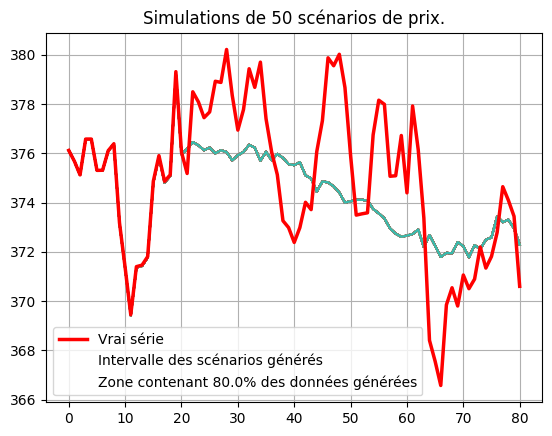

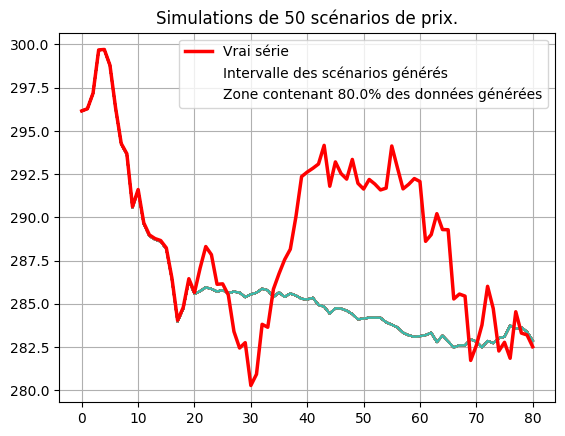

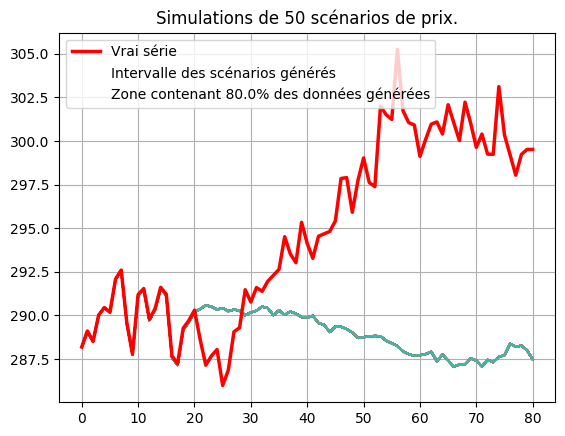

In [356]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50, reducer=30,j=0.8, alphas=[0.8,0,0], count_error=False)

On voit que tout les scénarios générés ont la même allure, c'est le problème de mode collapse. En affichant seulement les log return générés, on voit bien que les scénarios générés manquent beaucoup de diversité.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


311


array([[ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03,  8.0096908e-04,
         9.5488261e-03, -1.8102814e-05,  4.4379658e-03, -7.2852505e-04,
        -9.1245528e-03,  7.6559576e-04,  1.2962979e-03, -1.8664767e-03,
        -3.0613451e-03,  7.2929263e-03,  9.7670383e-04,  5.4004197e-03,
         3.4301591e-03,  6.1457525e-03,  7.1136230e-03, -6.3029409e-04,
         8.2458241e-04,  1.2144815e-03, -4.5767799e-04, -7.8522769e-04,
         3.9847085e-04, -9.0973248e-04,  4.5667525e-04, -2.8695576e-04,
        -1.3573356e-03,  8.2741940e-04,  5.3706358e-04,  1.1786969e-03,
        -4.5646410e-04, -2.1047404e-03,  1.4781173e-03, -1.3642226e-03,
         1.0207465e-03, -6.3243380e-04, -1.0129076e-03, -1.7702971e-04,
         5.2282214e-04, -2.1652982e-03, -5.4039166e-04, -2.1196473e-03,
         1.6749896e-03, -1.1834298e-04, -6.6314748e-04, -1.0013176e-03,
        -1.6304415e-03,  2.1952075e-04,  2.0824024e-04,  8.1677361e-05,
        -6.5089953e-05, -1.3844247e-03, -7.4661244e-04, -7.66789

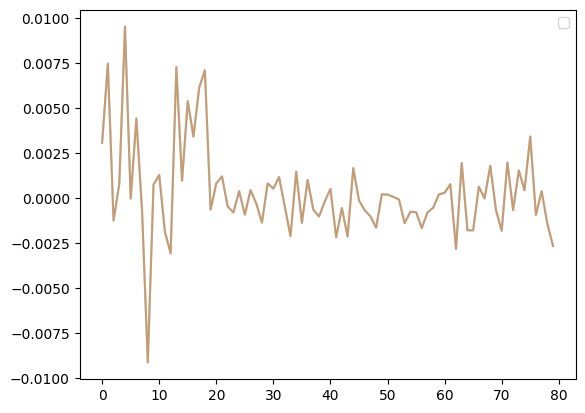

In [357]:
def show_generations(num, train, amplifier=1, reducer=4, show_real=True, alpha=0.3, start =random.randint(200,2000)):
    amplifier = 1
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(y[start:start+train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    v = np.array(v.float().cpu().detach()[:, 0,  :])
    print(start)
    for ar in v:
        plt.plot(ar, alpha=alpha)
    if show_real:
        plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
    plt.legend()
    return v
show_generations(2,train, reducer=20, alpha=0.5,show_real=False)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.017286


[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.990433
[t-SNE] KL divergence after 300 iterations: 3.718028


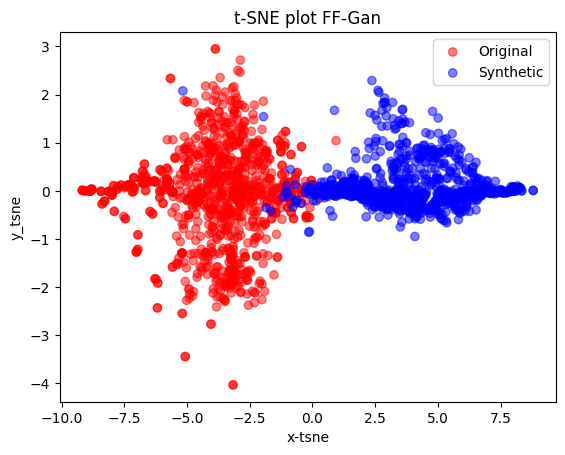

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.001s...
[t-SNE] Computed neighbors for 2020 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.017373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.911591
[t-SNE] KL divergence after 300 iterations: 3.516304


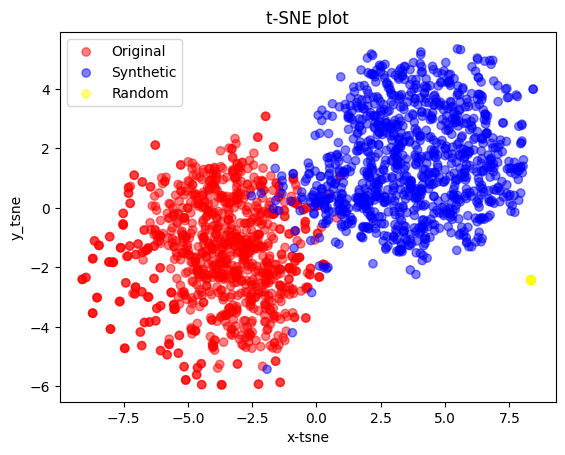

In [426]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=1000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False, title='t-SNE plot FF-Gan')
plot_tsne(real_array,fake_array, random=True)

Une première méthode simple pour éviter l'overfitting est de rajouter un paramètre de dropout

In [359]:
import torch
import torch.nn as nn

# On rajoute le dropout pour éviter l'overfitting
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition, dropout_rate=0.5):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Linear(256, ts_dim - condition),
            #nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, ts_dim, dropout_rate=0.4):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)


In [360]:
generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3, limite=20)
train.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  56272


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 11


311


array([[ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
         1.0913166e-02, -2.0991266e-03,  2.1484676e-03],
       [ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
         5.7168668e-03, -2.8415725e-03,  5.3038290e-03],
       [ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
        -6.1396084e-04,  8.0829632e-05,  7.6812627e-03],
       ...,
       [ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
        -1.8806708e-03,  1.4886697e-03,  3.2756135e-03],
       [ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
         5.6169173e-03, -4.2253374e-03,  2.3097934e-03],
       [ 3.0880263e-03,  7.4868896e-03, -1.2344144e-03, ...,
         8.6753601e-03, -7.9757897e-03,  3.6887736e-03]], dtype=float32)

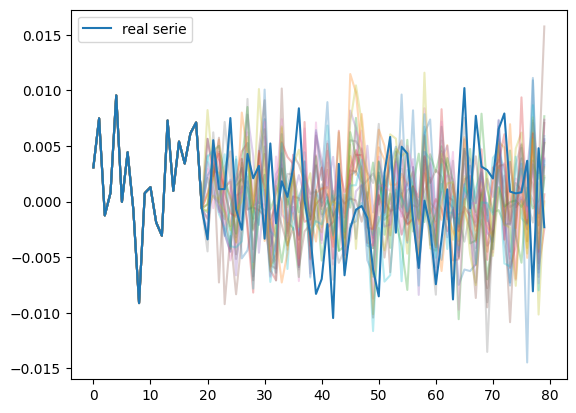

In [361]:
show_generations(20,train, reducer=13)

In [362]:
def generate_fake_scenario(input_, true_input, train, amplifier=1, num=5, reducer=5, j=False, alphas= [0.3,0.5,0.5], count_error=True):
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(input_[:train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    croissance = np.array(v.float().cpu().detach()[:, 0,  :])
    fake_lines = np.array([[true_input[0]] + [true_input[0] * np.prod(1 + croissance[i, :j+1]) for j in range(v.shape[2])] for i in range(num)])
    
    # Plot des faux scénarios
    for fake_line in fake_lines:
        plt.plot(fake_line, alpha=alphas[0])
    x = fake_lines[:, 1:]  
    min_x = np.min(x, axis=0)
    max_x = np.max(x, axis=0)     
    # Plot de la vraie série
    plt.plot(true_input[:len(fake_line)], label='Vrai série', linewidth=2.5, color="red")
    plt.fill_between(range(1,len(min_x)+1), min_x, max_x, color='blue', alpha=alphas[1])
    if type(j)==int:
        k = (num-j)//2
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if j<1 and j != False:
        k = int((num-(num*j))//2)
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if count_error:
        for i, val in enumerate(true_input[:len(fake_line)]):
            if i > train.conditional and i < len(min_x) + train.conditional and (val < min_x[i-1] or val > max_x[i-1]):
                plt.plot(i, val, '^', color='yellow', markersize=8)
        plt.plot([], [], '^', color='yellow', markersize=8, label='Sortie de l\'intervalle')
    plt.title(f"Simulations de {num} scénarios de prix.")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calcul du nombre de fois que la vraie série est en dehors de l'intervalle générée
    if count_error:
        y = true_input[:len(fake_line)]
        count = np.sum((y[train.conditional+1:] < min_x[train.conditional:]) | (y[train.conditional+1:] > max_x[train.conditional:]))
        
        print("-"*50, "\nNombre de fois que la vraie série est sortie de l'intervalle :\n", count, "sur ", v.shape[2], "\n", "-"*50)
    return 

673


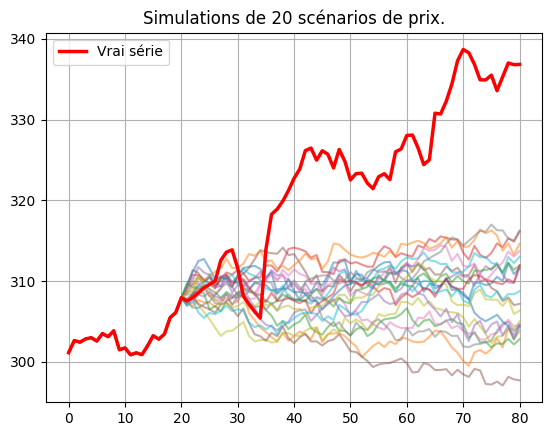

831


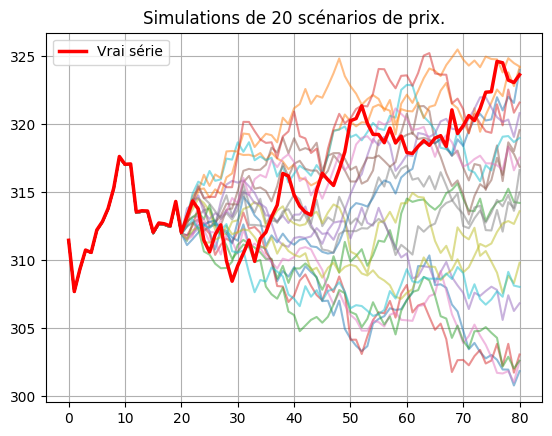

1117


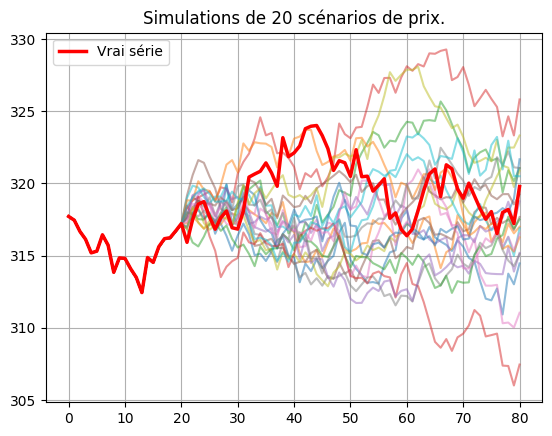

In [363]:
for i in range(3):
    start = random.randint(200,2000)
    print(start)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =20, reducer=18,j=0.8, alphas=[0.5,0,0], count_error=False)

738


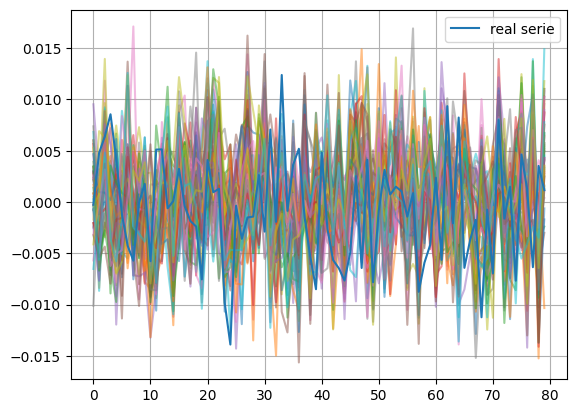

In [364]:
start = random.randint(200,2000)
num=50
amplifier = 1
noise = torch.randn((num, 1, train.latent_dim)) * amplifier
real_samples = torch.from_numpy(y[start:start+train.conditional])
noise[:, :, :train.conditional] = real_samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = noise.to(device)
v = train.G(noise) / 10
#v[:, :, :train.conditional] = real_samples
v = np.array(v.float().cpu().detach()[:, 0,  :])
print(start)
for ar in v:
    plt.plot(ar, alpha=0.5)
plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
plt.grid(True)
plt.legend()

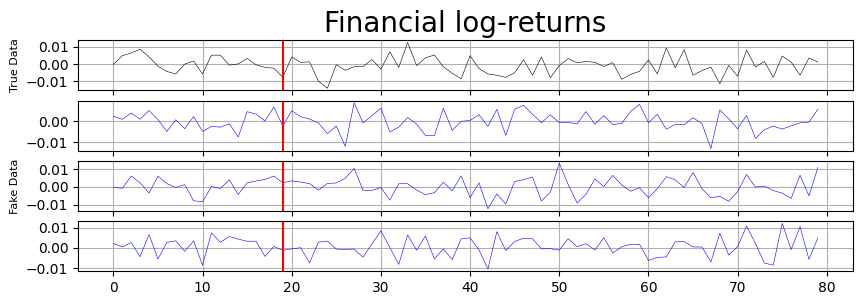

In [365]:
fig, axes = plt.subplots(4, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot( y[start:start+train.ts_dim-train.conditional], lw=0.4, color="black")
axes[0].set_ylabel(f"True Data", fontsize=8)
axes[0].grid(True)
axes[0].axvline(x=train.conditional-1, color='red', linestyle='-')
i=0
for arr in v:
    i+=1
    axes[i].grid(True)
    axes[i].plot(arr, lw=0.4, color="blue")
    axes[i].axvline(x=train.conditional-1, color='red', linestyle='-')
    if i==3:
        break
    
axes[2].set_ylabel(f"Fake Data", fontsize=8)
axes[2].yaxis.set_label_coords(-0.075, 0.5)

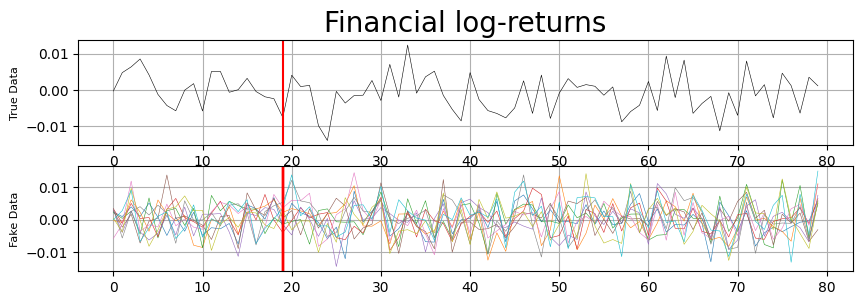

In [366]:
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(y[start:start+train.ts_dim-train.conditional], lw=0.4, color="black")
axes[0].set_ylabel(f"True Data", fontsize=8)
axes[0].grid(True)
axes[0].axvline(x=train.conditional-1, color='red', linestyle='-')

for i, arr in enumerate(v[:10], start=1):  # Enumerate over the first three fake data arrays
    axes[1].grid(True)
    axes[1].plot(arr, lw=0.4)
    axes[1].axvline(x=train.conditional-1, color='red', linestyle='-')

axes[1].set_ylabel(f"Fake Data", fontsize=8)
axes[1].yaxis.set_label_coords(-0.075, 0.5)

Le résultat est déjà plus satisfaisant

In [367]:
from utils.metrics import evaluate_fake_scenario

In [369]:
from utils.metrics import plot_tsne

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.025467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.917870
[t-SNE] KL divergence after 300 iterations: 4.904292


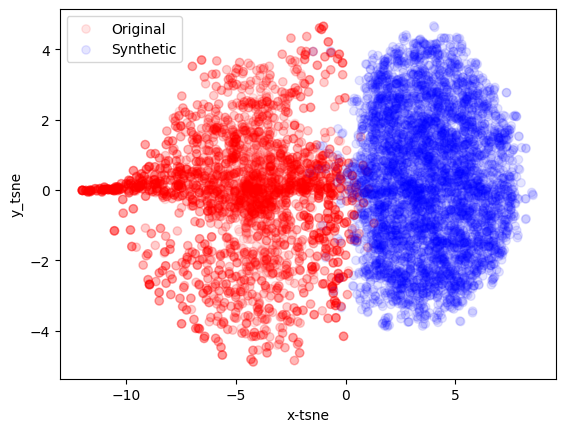

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10020 samples in 0.003s...
[t-SNE] Computed neighbors for 10020 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10020
[t-SNE] Computed conditional probabilities for sample 2000 / 10020
[t-SNE] Computed conditional probabilities for sample 3000 / 10020
[t-SNE] Computed conditional probabilities for sample 4000 / 10020
[t-SNE] Computed conditional probabilities for sample 5000 / 10020
[t-SNE] Computed conditional probabilities for sample 6000 / 10020
[t-SNE] Computed conditional probabilities for sample 7000 / 10020
[t-SNE] Computed conditional probabilities for sample 8000 / 10020
[t-SNE] Computed conditional probabilities for sample 9000 / 10020
[t-SNE] Computed conditional probabilities for sample 10000 / 10020
[t-SNE] Computed conditional probabilities for sample 10020 / 10020
[t-SNE] Mean sigma: 0.025492
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.919930
[t-SNE] KL

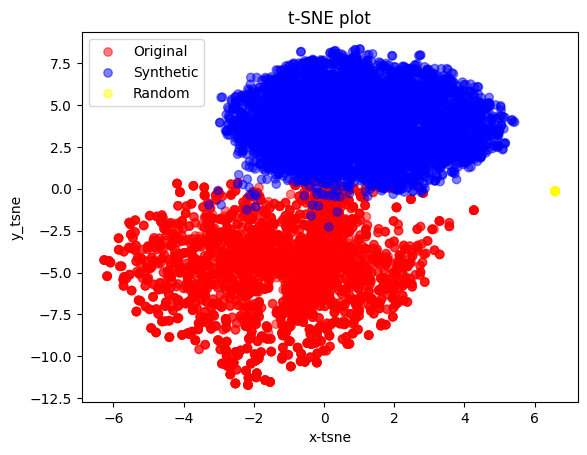

In [433]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=5000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False, alphas=[0.1,0.1], title='')
plot_tsne(real_array,fake_array, random=True)

In [371]:
from utils.metrics import get_moments
mom = get_moments(train, reducer=18)
mom

100%|██████████| 1000/1000 [00:08<00:00, 116.32it/s]


{'real mean': 0.00026824803,
 'fake mean': 2.6246296e-05,
 'real var': 4.7148773e-05,
 'fake var': 6.4030432e-06,
 'real skew': 0.4577293,
 'fake skew': 0.099393636,
 'real kurtosis': 4.1729164,
 'fake kurtosis': 0.72591203}

In [372]:
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator

In [373]:
generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout=0.5, hidden_dim=128)#, dropout_prob=0.2, hidden = 64)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_lstm = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3, is_recc=True, limite=20)
train_lstm.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  87120


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 24


311


array([[ 0.00308803,  0.00748689, -0.00123441, ...,  0.02724859,
         0.03891533,  0.02042613],
       [ 0.00308803,  0.00748689, -0.00123441, ...,  0.01659318,
         0.06355055, -0.00625697],
       [ 0.00308803,  0.00748689, -0.00123441, ...,  0.01975863,
         0.05092962,  0.00549865],
       ...,
       [ 0.00308803,  0.00748689, -0.00123441, ...,  0.0095712 ,
         0.049483  ,  0.00062391],
       [ 0.00308803,  0.00748689, -0.00123441, ...,  0.02302498,
         0.02285025,  0.04762897],
       [ 0.00308803,  0.00748689, -0.00123441, ...,  0.01190386,
         0.02832739,  0.00499061]], dtype=float32)

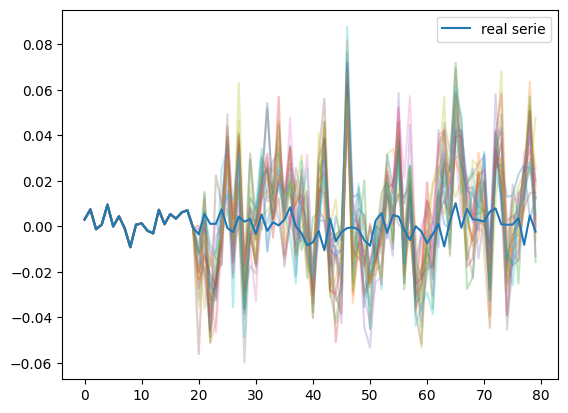

In [374]:
show_generations(train =train_lstm, num=20, reducer = 1)

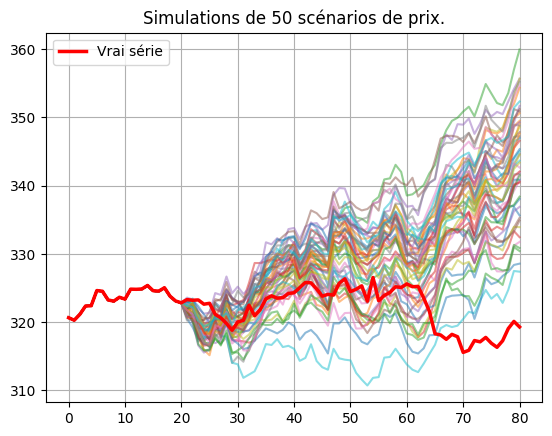

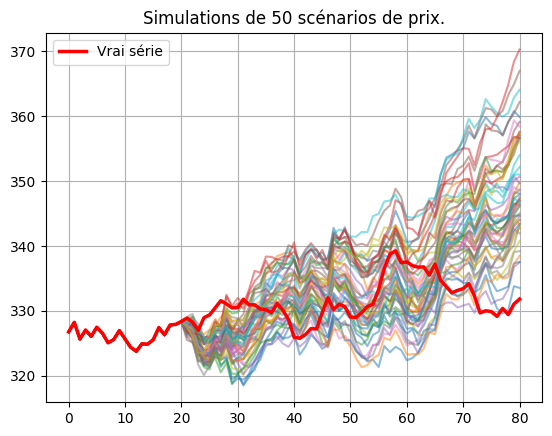

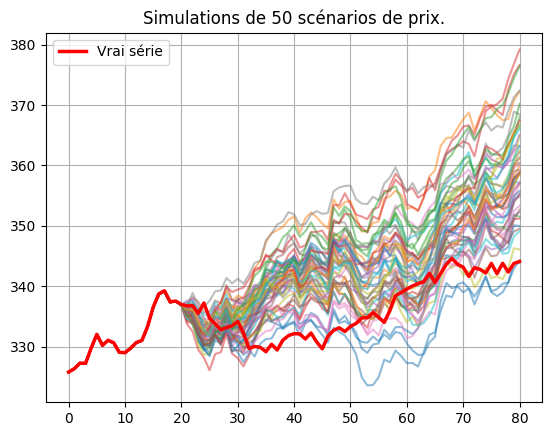

In [375]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train_lstm, amplifier = 1,num =50, reducer=5,j=0.8, alphas=[0.5,0,0], count_error=False)

In [376]:
from scipy.stats import kurtosis, skew
def get_moments(model,n=1000, batch_size = 50, reducer=1):
    """Calculer les estimateurs des 4 premiers moments sur les séries générées et réelles"

    Args:
        model : model de génération de données
        n (int, optional): nombre de sous échantillon. Defaults to 10000.
        batch_size (int, optional): taille des sous échantillons. Defaults to 50.


    """
    train = model
    real_mean = []
    fake_mean = []
    fake_var = []
    real_var = []
    real_skew = []
    real_kurt = []
    fake_skew = []
    fake_kurt = []
    for i in trange(n):
        fakes, real = train.data.get_samples(G=train.G, latent_dim=train.latent_dim, batch_size=batch_size, ts_dim=train.ts_dim,conditional=train.conditional,data= train.y, use_cuda=train.use_cuda)
        real_array = real.cpu().detach().numpy().reshape(batch_size,train.ts_dim)
        fake_array = fakes.cpu().detach().numpy().reshape(batch_size,train.ts_dim)/reducer
        fake_var.append(np.var(fake_array))
        real_var.append(np.var(real_array))
        fake_mean.append(np.mean(fake_array))
        real_mean.append(np.mean(real_array))
        fake_skew.append(skew(fake_array))
        real_skew.append(skew(real_array))
        fake_kurt.append(kurtosis(fake_array))
        real_kurt.append(kurtosis(real_array))
    return {"real mean":np.mean(real_mean), "fake mean": np.mean(fake_mean), "real var":np.mean(real_var), "fake var":np.mean(fake_var),"real skew": np.mean(real_skew), "fake skew": np.mean(fake_skew),
    "real kurtosis":np.mean(real_kurt), "fake kurtosis": np.mean(fake_kurt)}



[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.021446


[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.487442
[t-SNE] KL divergence after 300 iterations: 4.753176


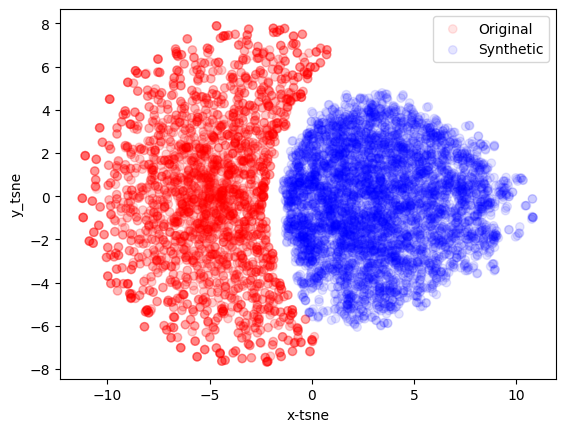

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10020 samples in 0.001s...
[t-SNE] Computed neighbors for 10020 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10020
[t-SNE] Computed conditional probabilities for sample 2000 / 10020
[t-SNE] Computed conditional probabilities for sample 3000 / 10020
[t-SNE] Computed conditional probabilities for sample 4000 / 10020
[t-SNE] Computed conditional probabilities for sample 5000 / 10020
[t-SNE] Computed conditional probabilities for sample 6000 / 10020
[t-SNE] Computed conditional probabilities for sample 7000 / 10020
[t-SNE] Computed conditional probabilities for sample 8000 / 10020
[t-SNE] Computed conditional probabilities for sample 9000 / 10020
[t-SNE] Computed conditional probabilities for sample 10000 / 10020
[t-SNE] Computed conditional probabilities for sample 10020 / 10020
[t-SNE] Mean sigma: 0.021468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.473351
[t-SNE] KL

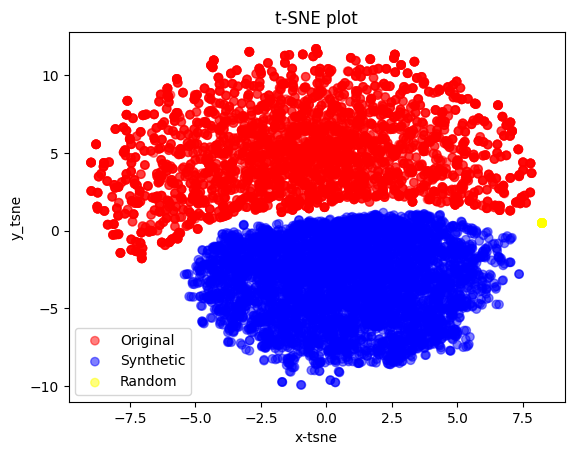

In [434]:
fake , real = train_lstm.data.get_samples(G = train_lstm.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=5000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False,alphas=[0.1,0.1], title='')
plot_tsne(real_array,fake_array, random=True)

In [378]:
from utils.network import Generator#, Discriminator

In [379]:
class Discriminator(nn.Module):
    def __init__(self, ts_dim, dropout_prob=0.5):
        super(Discriminator, self).__init__()
        self.ts_dim = ts_dim
        self.dropout_prob = dropout_prob
        
        self.ts_to_feature = nn.Sequential(
            nn.Linear(self.ts_dim, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=self.dropout_prob)
        )
        self.block = nn.Sequential(    
            nn.Linear(512, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=self.dropout_prob)
        )
        self.to_score = nn.Sequential(
            nn.Linear(512, 1)
        )

    def forward(self, input_data):
        x = self.ts_to_feature(input_data)
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x = self.to_score(x)
        
        return x

In [380]:
class gen_model():
    def __init__(self, data ,generator, critic, gen_optimizer, critic_optimizer, batch_size, path, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=3,gp_weight=10,critic_iter=5, 
    n_eval=20, use_cuda=False, _lambda= 1, n=100, is_recc=False, limite = 10, window = 1
    ,vega=np.inf, theta=5):
        self.G = generator
        self.D = critic
        self.G_opt = gen_optimizer
        self.D_opt = critic_optimizer
        self.G_scheduler = G_scheduler
        self.D_scheduler = D_scheduler
        self.batch_size = batch_size
        self.scorepath = path
        self.gp_weight = gp_weight
        self.critic_iter = critic_iter
        self.n_eval = n_eval
        self.use_cuda = use_cuda
        self.conditional = conditional
        self.ts_dim = ts_dim
        self.data = Data(data,ts_dim, window)
        self.y = data
        self.diff_mean = []
        self.diff_var = []
        self.score = []
        self.current_score = np.inf
        self._lambda = _lambda
        self.n=n
        self.best_epoch = None
        self.is_recc = is_recc
        self.stopper = 0
        self.limite = limite
        self.vega = vega
        self.theta = theta


        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

        
        self.latent_dim = latent_dim
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': [], 'LR_G': [], 'LR_D':[]}

    def train_model(self, epochs, compute_score=True):
        pb = trange(epochs, leave=False)
        for epoch in pb:
            for i in range(self.critic_iter):
                fake_batch, real_batch = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
                if self.use_cuda:
                    real_batch = real_batch.cuda()
                    fake_batch = fake_batch.cuda()
                    self.D.cuda()
                    self.G.cuda()
                if self.is_recc:
                    with torch.backends.cudnn.flags(enabled=False):
                        d_real = self.D(real_batch)
                        d_fake = self.D(fake_batch)

                        grad_penalty, grad_norm_ = self._grad_penalty(real_batch, fake_batch)
                        self.D_opt.zero_grad()
                        
                        d_loss = d_fake.mean() - d_real.mean() + grad_penalty.to(torch.float32)
                        d_loss.backward()
                        self.D_opt.step()
                else:
                    d_real = self.D(real_batch)
                    d_fake = self.D(fake_batch)

                    grad_penalty, grad_norm_ = self._grad_penalty(real_batch, fake_batch)
                    self.D_opt.zero_grad()
                    
                    d_loss = d_fake.mean() - d_real.mean() + grad_penalty.to(torch.float32)
                    d_loss.backward()
                    self.D_opt.step()
                if i == self.critic_iter-1:
                    self.D_scheduler.step()
                    self.losses['LR_D'].append(self.D_scheduler.get_lr())
                    self.losses['D'].append(float(d_loss))
                    self.losses['GP'].append(grad_penalty.item())
                    self.losses['gradient_norm'].append(float(grad_norm_))
                    if compute_score:
                        temp_mean, temp_var = comp_mean_var(self, n=self.n, batch_size = self.batch_size)
                        self.diff_mean.append(temp_mean)
                        self.diff_var.append(temp_var)
                        actual_score = temp_mean + self._lambda * temp_var
                        self.score.append(actual_score)
                        self.stopper+=1
                        if self.stopper == self.limite:
                            self.G.load_state_dict(torch.load(self.scorepath + '/gen_'+ f"epoch" + '.pt'))
                            print(f"Arret préliminaire, aucune amélioration du modèle depuis {self.limite} epochs")
                            print(f"Last epoch : {self.best_epoch}")
                            return
                        if actual_score < self.current_score:
                            self.stopper = 0
                            pb.set_description(f"best score : {actual_score} epoch : {epoch}")
                            torch.save(self.G.state_dict(), self.scorepath + '/gen_'+ f"epoch" + '.pt')
                            torch.save(self.D.state_dict(), self.scorepath + '/dis_'  + f"epoch" + '.pt') 
                            self.current_score = actual_score
                            self.best_epoch = epoch
                
            self.G_opt.zero_grad()
            fake_batch_critic, real_batch_critic = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
            if self.use_cuda:
                real_batch_critic = real_batch_critic.cuda()
                fake_batch_critic = fake_batch_critic.cuda()
                self.D.cuda()
                self.G.cuda()
            # feed-forward
            d_critic_fake = self.D(fake_batch_critic)

            g_loss =  - d_critic_fake.mean()  # d_critic_real.mean()
            # backprop
            if self.is_recc:
                with torch.backends.cudnn.flags(enabled=False): 
                    g_loss.backward()
            else:
                g_loss.backward()
            self.G_opt.step()
            self.G_scheduler.step()
            self.losses['LR_G'].append(self.G_scheduler.get_lr())

            # save the loss of feed forward
            self.losses['G'].append(g_loss.item())  # outputs tensor with single value
            if (epoch + 1) % (10*self.n_eval) == 0:
                fake_lines, real_lines = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
                self.real_lines = np.squeeze(real_lines.cpu().data.numpy())
                self.fake_lines = np.squeeze(fake_lines.cpu().data.numpy())
                plt_progress(self.fake_lines, self.real_lines,epoch, "./logs")

            fake_lines, real_lines = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
            self.real_lines = np.squeeze(real_lines.cpu().data.numpy())
            self.fake_lines = np.squeeze(fake_lines.cpu().data.numpy())
            if (epoch + 1) % 500 ==0:
                name = 'CWGAN-GP_model_Dense3_concat_fx'
                #torch.save(self.G.state_dict(), self.scorepath + '/gen_' + name + '.pt')
                #torch.save(self.D.state_dict(), self.scorepath + '/dis_' + name + '.pt')    
        self.G.load_state_dict(torch.load(self.scorepath + '/gen_'+ f"epoch" + '.pt'))



    def _grad_penalty(self, real_data, gen_data):
        batch_size = real_data.size()[0]
        t = torch.rand((batch_size, 1, 1), requires_grad=True)
        t = t.expand_as(real_data)

        if self.use_cuda:
            t = t.cuda()

        # mixed sample from real and fake; make approx of the 'true' gradient norm
        interpol = t * real_data.data + (1-t) * gen_data.data

        if self.use_cuda:
            interpol = interpol.cuda()
        
        prob_interpol = self.D(interpol)
        torch.autograd.set_detect_anomaly(True)
        gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                               grad_outputs=torch.ones(prob_interpol.size()).cuda() if self.use_cuda else torch.ones(
                                   prob_interpol.size()), create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(batch_size, -1)
        diff = torch.max(real_data) - torch.min(real_data)
 
        
        # Si la différence dépasse vega, multiplier grad_penalty par theta
        if diff > self.vega:

            grad_penalty = self.gp_weight * self.theta * (torch.max(torch.zeros(1).cuda() if self.use_cuda else torch.zeros(1), gradients.norm(2, dim=1).mean() - 1) ** 2)
        else:
            grad_penalty = self.gp_weight * (torch.max(torch.zeros(1).cuda() if self.use_cuda else torch.zeros(1), gradients.norm(2, dim=1).mean() - 1) ** 2)

        # add epsilon for stability
        eps = 1e-10
        gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)

        return grad_penalty, gradients_norm.mean().item()


In [381]:
y.shape

(2494,)

In [382]:
generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout_prob=0.4, hidden=128)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-6
lr_b = 1e-6
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_cnn = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, 
                    D_scheduler, G_scheduler, conditional=conditional,
                    use_cuda=use_cuda, _lambda=2, limite=20, window=1, vega = np.inf,theta = 20)
train_cnn.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  273242


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                                  

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 152


311


array([[ 3.08802631e-03,  7.48688960e-03, -1.23441441e-03,
         8.00969079e-04,  9.54882614e-03, -1.81028136e-05,
         4.43796581e-03, -7.28525047e-04, -9.12455283e-03,
         7.65595760e-04,  1.29629788e-03, -1.86647673e-03,
        -3.06134508e-03,  7.29292631e-03,  9.76703828e-04,
         5.40041970e-03,  3.43015906e-03,  6.14575250e-03,
         7.11362297e-03, -6.30294089e-04, -0.00000000e+00,
        -0.00000000e+00, -3.18072806e-03, -4.73589935e-05,
        -1.16384275e-04, -1.25215261e-03,  4.07961942e-03,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.44970899e-03,
        -5.38609922e-03, -2.33660522e-03, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -5.04962774e-03,
        -0.00000000e+00,  0.00000000e+00,  2.22798623e-03,
        -0.00000000e+00, -4.08328429e-04, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -6.98797405e-04,
        -3.71486577e-03,  0.00000000e+00,  1.33359118e-0

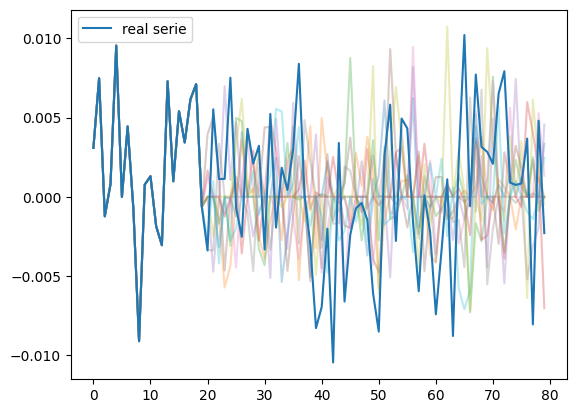

In [383]:
show_generations(train = train_cnn,num=10, reducer=5)

In [384]:
def generate_fake_scenario(input_, true_input, train, amplifier=1, num=5, reducer=5, j=False, alphas= [0.3,0.5,0.5], count_error=True):
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(input_[:train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    croissance = np.array(v.float().cpu().detach()[:, 0,  :])
    fake_lines = np.array([[true_input[0]] + [true_input[0] * np.prod(1 + croissance[i, :j+1]) for j in range(v.shape[2])] for i in range(num)])
    
    # Plot des faux scénarios
    for fake_line in fake_lines:
        plt.plot(fake_line, alpha=alphas[0])
    x = fake_lines[:, 1:]  
    min_x = np.min(x, axis=0)
    max_x = np.max(x, axis=0)     
    # Plot de la vraie série
    plt.plot(true_input[:len(fake_line)], label='Vrai série', linewidth=2.5, color="red")
    plt.fill_between(range(1,len(min_x)+1), min_x, max_x, color='blue', alpha=alphas[1])
    if type(j)==int:
        k = (num-j)//2
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if j<1 and j != False:
        k = int((num-(num*j))//2)
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if count_error:
        for i, val in enumerate(true_input[:len(fake_line)]):
            if i > train.conditional and i < len(min_x) + train.conditional and (val < min_x[i-1] or val > max_x[i-1]):
                plt.plot(i, val, '^', color='yellow', markersize=8)
        plt.plot([], [], '^', color='yellow', markersize=8, label='Sortie de l\'intervalle')
    plt.title(f"Simulations de {num} scénarios de prix.")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calcul du nombre de fois que la vraie série est en dehors de l'intervalle générée
    if count_error:
        y = true_input[:len(fake_line)]
        count = np.sum((y[train.conditional+1:] < min_x[train.conditional:]) | (y[train.conditional+1:] > max_x[train.conditional:]))
        
        print("-"*50, "\nNombre de fois que la vraie série est sortie de l'intervalle :\n", count, "sur ", v.shape[2], "\n", "-"*50)
    return fake_lines

In [512]:
def generate_fake_scenario(input_, true_input, train, amplifier=1, num=5, reducer=5, j=False, alphas= [0.3,0.5,0.5], count_error=True):
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(input_[:train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    croissance = np.array(v.float().cpu().detach()[:, 0,  :])
    fake_lines = np.array([[true_input[0]] + [true_input[0] * np.prod(1 + croissance[i, :j+1]) for j in range(v.shape[2])] for i in range(num)])
    
    # Plot des faux scénarios
    for fake_line in fake_lines:
        plt.plot(fake_line, alpha=alphas[0])
    x = fake_lines[:, 1:]  
    min_x = np.min(x, axis=0)
    max_x = np.max(x, axis=0)     
    # Plot de la vraie série
    plt.plot(true_input[:len(fake_line)], label='Real sample', linewidth=2.5, color="red")
    plt.fill_between(range(1,len(min_x)+1), min_x, max_x, color='blue', alpha=alphas[1])
    if type(j)==int:
        k = (num-j)//2
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if j<1 and j != False:
        k = int((num-(num*j))//2)
        x_small = np.partition(x, k, axis=0)[k]
        x_big = np.partition(x, -k-1, axis=0)[-k-1]
        plt.fill_between(range(1,len(min_x)+1), x_small, x_big, color='red', alpha=alphas[2])
    if count_error:
        for i, val in enumerate(true_input[:len(fake_line)]):
            if i > train.conditional and i < len(min_x) + train.conditional and (val < min_x[i-1] or val > max_x[i-1]):
                plt.plot(i, val, '^', color='yellow', markersize=8)
        plt.plot([], [], '^', color='yellow', markersize=8, label='Sortie de l\'intervalle')
    #plt.title(f"Simulations de {num} scénarios de prix.")
    #plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calcul du nombre de fois que la vraie série est en dehors de l'intervalle générée
    if count_error:
        y = true_input[:len(fake_line)]
        count = np.sum((y[train.conditional+1:] < min_x[train.conditional:]) | (y[train.conditional+1:] > max_x[train.conditional:]))
        
        print("-"*50, "\nNombre de fois que la vraie série est sortie de l'intervalle :\n", count, "sur ", v.shape[2], "\n", "-"*50)
    return 

727


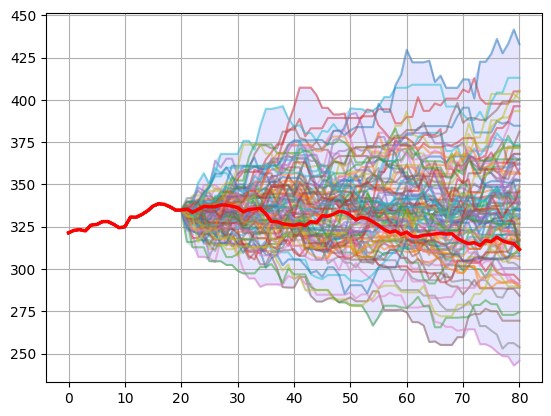

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 sur  80 
 --------------------------------------------------


In [556]:
start = random.randint(200,2000)
print(start)
#start=543
generate_fake_scenario(y[start:],true_y[start:],train_cnn, amplifier = 1,num =100, reducer=1,j=0.8, alphas=[0.5,0.1,0], count_error=True)

In [559]:
def evaluate_fake_scenario(input_, true_input, train, n=500,amplifier = 1, num = 5, reducer=5, no_print=False):
    """Compte le nombre de fois en moyenne ou le vrai scénario est en dehors des intervalles de faux scénarios générés

    Args:
        input_ (array): Array de la série des logs returns
        true_input (array): Array de la vraie série
        train (Model): Modèle de génération de données
        n (int, optional): Nombre de fois que évalue le modèle. Defaults to 500.
        amplifier (int, optional): Amplifier le bruit du générateur. Defaults to 1.
        num (int, optional): nombre de séries générées à chaque évaluation. Defaults to 5.
        reducer (int, optional): Réduire l'amplitude des séries générées. Defaults to 5.
        no_print (bool, optional): affichage ou non du résultat. Defaults to False.

    Returns:
        int: score du modèle
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_count = 0
    pb = trange(n, leave=False)
    for j in pb:
        start = random.randint(0, 2000)
        in_ = input_[start:]
        true_in_ = true_input[start:]
        big_arr = np.empty((train.ts_dim))

        noise = torch.randn((num, 1, train.latent_dim)) * amplifier
        real_samples = torch.from_numpy(input_[:train.conditional])
        noise[:, :, :train.conditional] = real_samples
        

        noise = noise.to(device)
        v = train.G(noise) / reducer
        v[:, :, :train.conditional] = real_samples
        croissance = np.array(v.float().cpu().detach()[:, 0,  :])
        fake_lines = np.array([[true_input[0]] + [true_input[0] * np.prod(1 + croissance[i, :j+1]) for j in range(v.shape[2])] for i in range(num)])
        
        # Calcul du nombre de fois que la vraie série est en dehors de l'intervalle
        x = fake_lines 
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        y = true_input[:train.ts_dim+1-train.conditional]
        count = np.sum((y[train.conditional+1:] < min_x[train.conditional+1:]) | (y[train.conditional+1:] > max_x[train.conditional+1:]))
        pb.set_description(f"Nombre d'erreur : {count}")
        total_count += count
    if not no_print:
        print("-"*100,f"\nMoyenne du nombre de fois que la vraie série est sortie de l'intervalle sur {n} simulations pour {num} scénarios simulés :\n", total_count/n, "\n", "-"*100)
    return total_count/n

In [572]:
list_val_base=[]
pb = trange(100)
for k in pb:
    score = evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = k+2,reducer=15, n=200, no_print=True)
    pb.set_description(f"Nombre d'erreur moyenne pour {k+2} scénarios : {score}/{train.ts_dim-10}")
    list_val_base.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Nombre d'erreur moyenne pour 101 scénarios : 3.155/90: 100%|██████████| 100/100 [11:49<00:00,  7.10s/it]


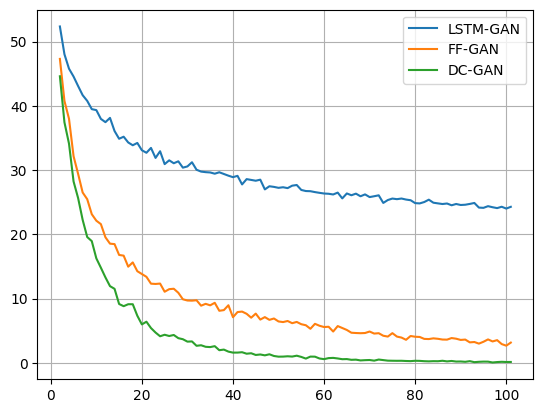

In [578]:
plt.plot(indices ,list_val_lstm, label='LSTM-GAN')
plt.plot(indices, list_val_base, label='FF-GAN')
plt.plot(indices, list_val, label="DC-GAN")
plt.legend()
plt.grid(True)

In [569]:
list_val_lstm=[]
pb = trange(100)
for k in pb:
    score = evaluate_fake_scenario(y[200:],true_y[200:],train_lstm, amplifier = 1,num = k+2,reducer=10, n=200, no_print=True)
    pb.set_description(f"Nombre d'erreur moyenne pour {k+2} scénarios : {score}/{train.ts_dim-10}")
    list_val_lstm.append(score)
indices = range(2, len(list_val) + 2)
list_val_base=[]
pb = trange(100)
for k in pb:
    score = evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = k+2,reducer=10, n=200, no_print=True)
    pb.set_description(f"Nombre d'erreur moyenne pour {k+2} scénarios : {score}/{train.ts_dim-10}")
    list_val_base.append(score)
plt.plot(indices, list_val)
plt.title(f"Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à {len(list_val) + 2} ")
plt.grid(True)
plt.show()

Nombre d'erreur moyenne pour 101 scénarios : 24.285/90: 100%|██████████| 100/100 [11:46<00:00,  7.07s/it]
  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'train_base' is not defined

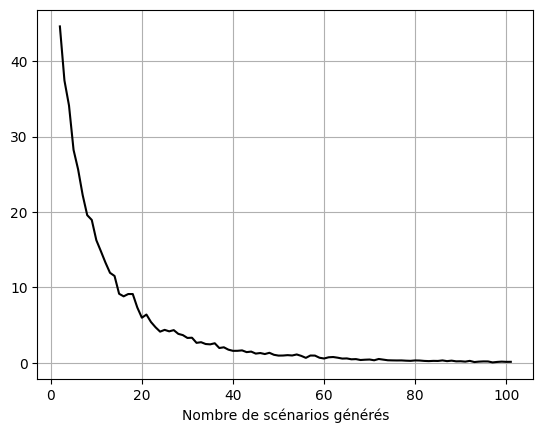

In [568]:
indices = range(2, len(list_val) + 2)
plt.plot(indices, list_val, color='black')
plt.xlabel('Nombre de scénarios générés')

plt.grid(True)

In [558]:
list_val

[40.69,
 30.55,
 23.44,
 17.81,
 15.685,
 13.62,
 12.38,
 11.665,
 11.635,
 11.13,
 10.675,
 10.41,
 10.54,
 10.545,
 10.39,
 10.1,
 10.14,
 10.165,
 10.14,
 10.015,
 10.09,
 10.055,
 10.015,
 10.05,
 10.03,
 10.015,
 10.015,
 10.025,
 10.0,
 10.01,
 10.005,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.005,
 10.005,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0]

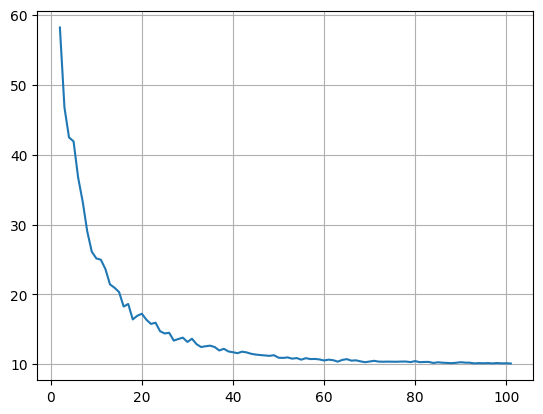

In [551]:
plt.plot(indices, list_val)
#plt.title(f"Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à {len(list_val) + 2} ")
plt.grid(True)
plt.show()

620


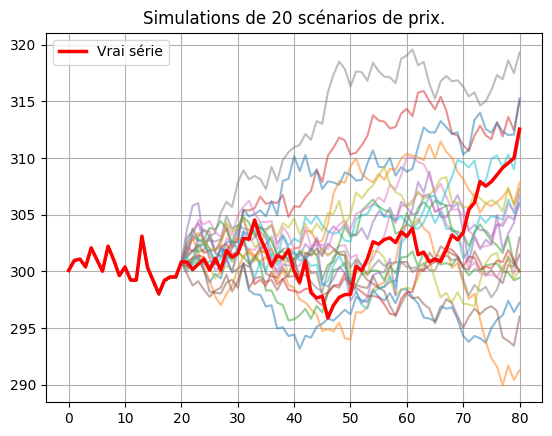

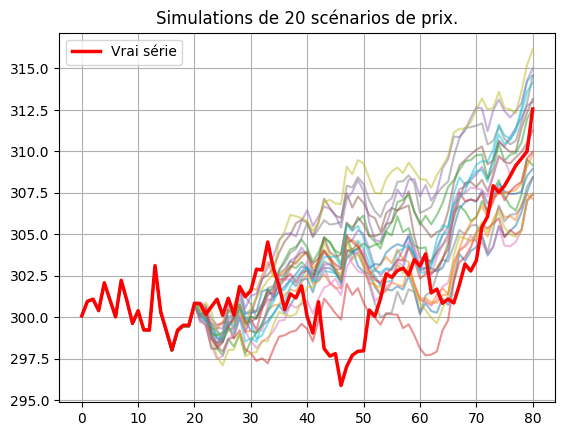

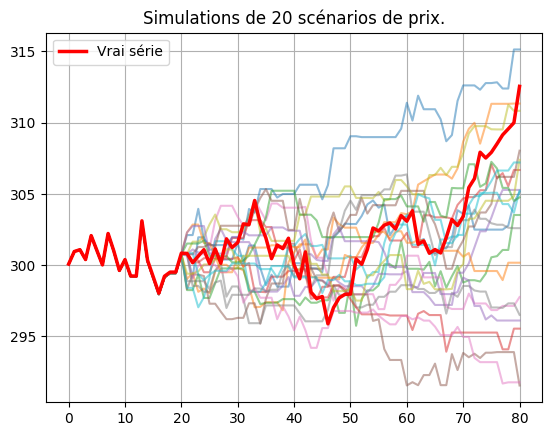

In [385]:
start = random.randint(200,2000)
print(start)
fake_base = generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =20, reducer=15,j=0.8, alphas=[0.5,0,0], count_error=False)
fake_lstm = generate_fake_scenario(y[start:],true_y[start:],train_lstm, amplifier = 1,num =20, reducer=10,j=0.8, alphas=[0.5,0,0], count_error=False)
fake_cnn = generate_fake_scenario(y[start:],true_y[start:],train_cnn, amplifier = 1,num =20, reducer=5,j=0.8, alphas=[0.5,0,0], count_error=False)

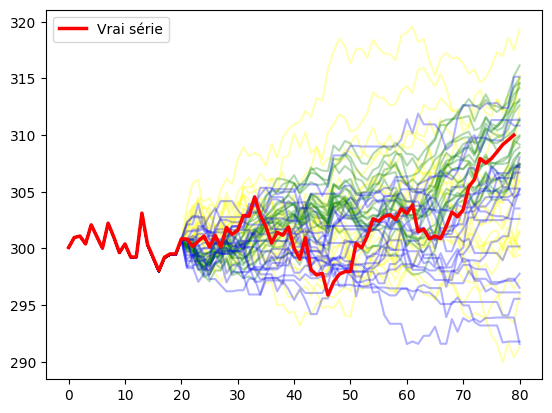

In [386]:
for line in fake_base:
    if i==0:
        plt.plot(line, color="yellow", alpha=0.3, label="BASE GAN")
        i+=1
    else:
        plt.plot(line, color="yellow", alpha=0.3)
for line in fake_lstm:
    plt.plot(line, color="green", alpha=0.3)
for line in fake_cnn:
    plt.plot(line, color="blue", alpha=0.3)
plt.plot(true_y[start:start+80], label='Vrai série', linewidth=2.5, color="red")
plt.legend()

1826


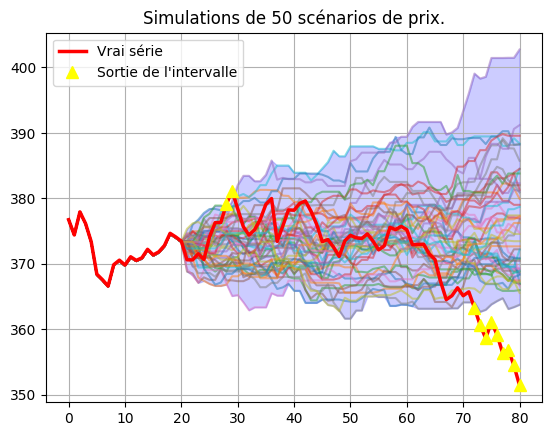

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 11 sur  80 
 --------------------------------------------------
1299


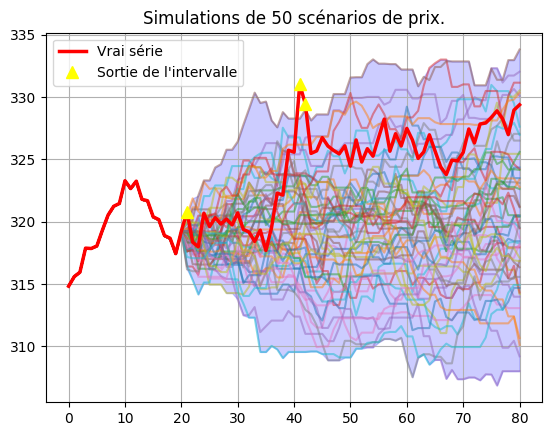

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 3 sur  80 
 --------------------------------------------------
1250


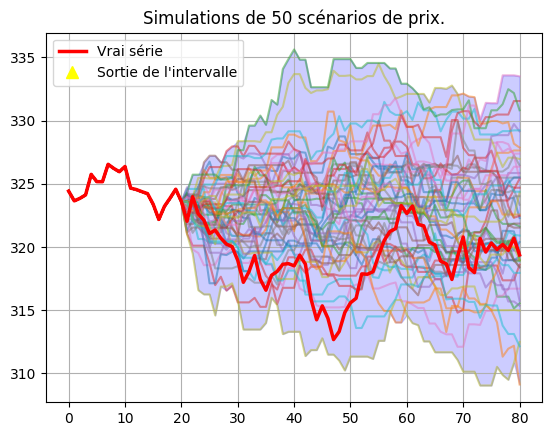

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 sur  80 
 --------------------------------------------------


In [387]:
for i in range(3):
    start = random.randint(200,2000)
    print(start)
    generate_fake_scenario(y[start:],true_y[start:],train_cnn, amplifier = 1,num =50, reducer=5,j=0.8, alphas=[0.5,0.2,0], count_error=True)

1628


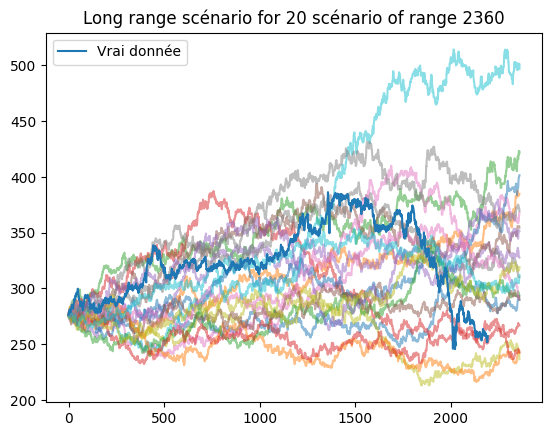

In [423]:
start = random.randint(200,2000)
print(start)
start=300
v, fake_lines = generate_long_range(y[start:], true_y[start:], train_cnn, length=3000, n=20, reducer=3, amplifier=1)

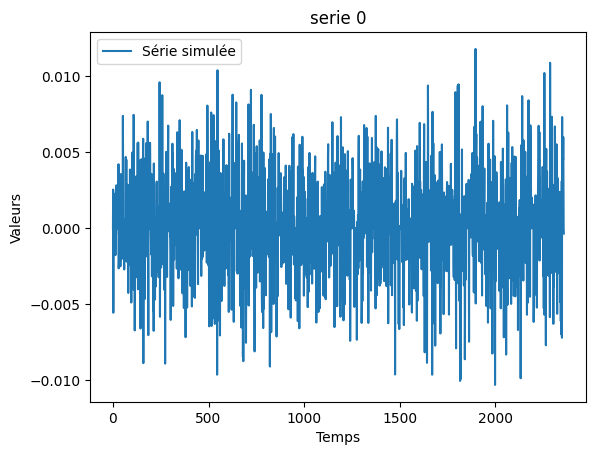

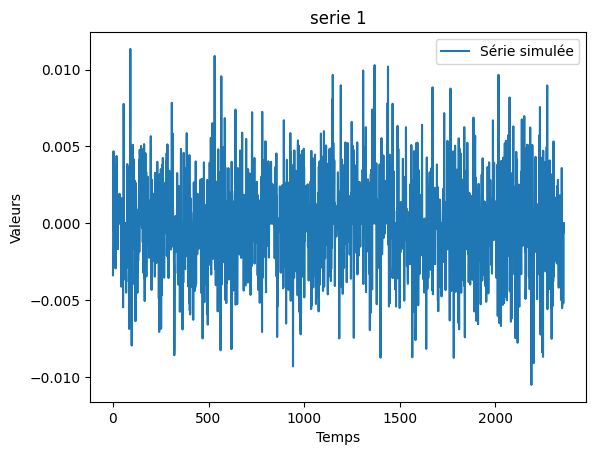

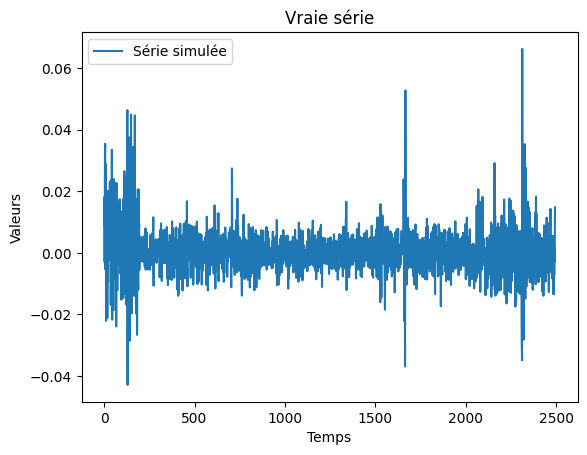

In [389]:
for i in range(2):
    x_hat = np.log(fake_lines[i,1:] / fake_lines[i,:-1])
    simple_plot(x_hat, title=f"serie {i}")
simple_plot(y, title="Vraie série")

In [447]:
sd

0.007096802163277801

/tmp/ipykernel_28778/2070153006.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(x_hat, hist=True, kde=True, label='VIX log-returns dist',
/home/onyxia/work/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_28778/2070153006.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
si

<Axes: ylabel='Density'>

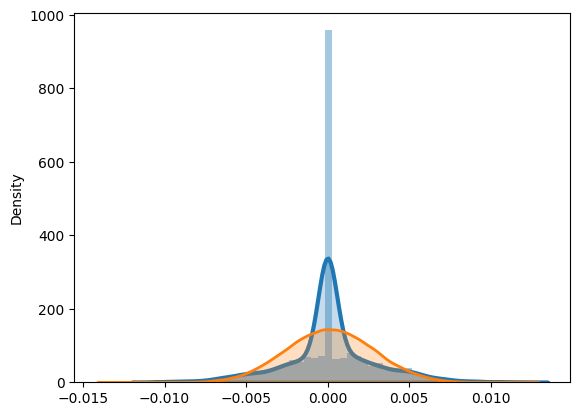

In [390]:
import seaborn as sb
i=0
x_hat = np.log(fake_lines[i,1:] / fake_lines[i,:-1])
m ,sd = x_hat.mean(), x_hat.std()
sb.distplot(x_hat, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(m, sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

/tmp/ipykernel_28778/2291954721.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(y, hist=True, kde=True, label='VIX log-returns dist',
/home/onyxia/work/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_28778/2291954721.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simila

<Axes: ylabel='Density'>

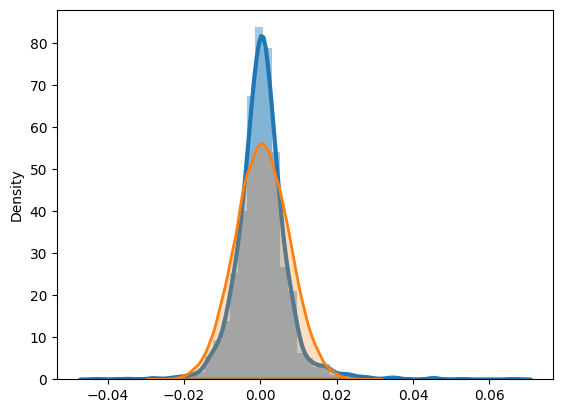

In [448]:
m ,sd = y.mean(), y.std()
sb.distplot(y, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(m, sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

/tmp/ipykernel_28778/1075077985.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(x_hat, hist=True, kde=True, label='VIX log-returns dist',
/home/onyxia/work/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_28778/1075077985.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
si

<Axes: ylabel='Density'>

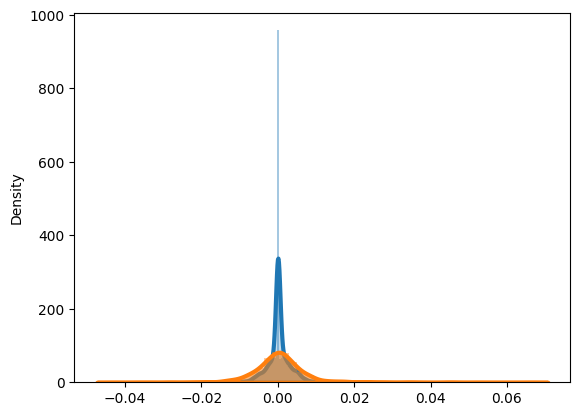

In [392]:
x_hat = np.log(fake_lines[i,1:] / fake_lines[i,:-1])
sb.distplot(x_hat, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sb.distplot(y, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})

In [425]:
from sklearn.manifold import TSNE

def plot_tsne(real_array, fake_array, random=False, num_random=20, alphas=[0.5,0.5,0.5], hyper_p={"n_components":2, "verbose":1, "perplexity":10, "n_iter":300}, title= "t-SNE plot"):
    tsne = TSNE(n_components=hyper_p["n_components"], verbose=hyper_p["verbose"], perplexity=hyper_p["perplexity"], n_iter=hyper_p["n_iter"])
    num_real = real_array.shape[0]  
    len_real = real_array.shape[2] 
    num_fake = fake_array.shape[0]
    if random:
        array_full = np.concatenate((np.squeeze(real_array), np.squeeze(fake_array), np.random.rand(num_random, len_real)), axis = 0)
        colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] + ["yellow" for i in range(num_random)] 
    else:
        array_full = np.concatenate((np.squeeze(real_array), np.squeeze(fake_array)), axis = 0)
        colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] 
    tsne_results = tsne.fit_transform(array_full)
    #colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] + ["yellow" for i in range(num_real)] 
    f, ax = plt.subplots(1)
        
    plt.scatter(tsne_results[:num_real,0], tsne_results[:num_real,1], 
                c = colors[:num_real], alpha = alphas[0], label = "Original")
    plt.scatter(tsne_results[num_real:num_real + num_fake,0], tsne_results[num_real: num_real + num_fake,1], 
                c = colors[num_real:num_real + num_fake], alpha = alphas[1], label = "Synthetic")
    if random:
        plt.scatter(tsne_results[num_real+num_fake:,0], tsne_results[num_real*2:,1], 
                c = colors[num_real+num_fake:], alpha = alphas[2], label = "Random")

    ax.legend()
        
    plt.title(title)
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.015213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.977760
[t-SNE] KL divergence after 300 iterations: 4.835027


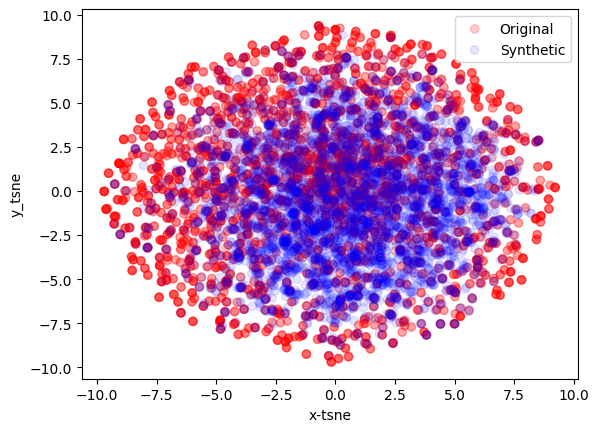

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10020 samples in 0.001s...
[t-SNE] Computed neighbors for 10020 samples in 0.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10020
[t-SNE] Computed conditional probabilities for sample 2000 / 10020
[t-SNE] Computed conditional probabilities for sample 3000 / 10020
[t-SNE] Computed conditional probabilities for sample 4000 / 10020
[t-SNE] Computed conditional probabilities for sample 5000 / 10020
[t-SNE] Computed conditional probabilities for sample 6000 / 10020
[t-SNE] Computed conditional probabilities for sample 7000 / 10020
[t-SNE] Computed conditional probabilities for sample 8000 / 10020
[t-SNE] Computed conditional probabilities for sample 9000 / 10020
[t-SNE] Computed conditional probabilities for sample 10000 / 10020
[t-SNE] Computed conditional probabilities for sample 10020 / 10020
[t-SNE] Mean sigma: 0.015228
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.966080
[t-SNE] KL

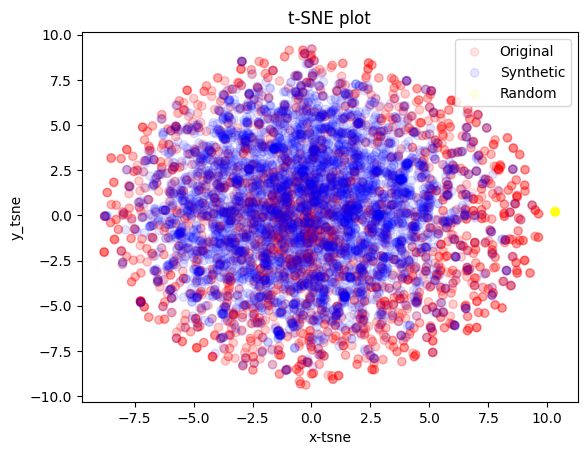

In [437]:
fake , real = train_cnn.data.get_samples(G = train_cnn.G, latent_dim = train_cnn.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=5000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake /1
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False, alphas=[0.2,0.1, 1], title='')
plot_tsne(real_array,fake_array, random=True, alphas=[0.1,0.1,0.1])

In [395]:
Moments_base = get_moments(train, reducer=15)
Moments_lstm = get_moments(train_lstm, reducer=10)
Moments_cnn = get_moments(train_cnn, reducer= 5)

  2%|▏         | 23/1000 [00:00<00:09, 107.70it/s]

100%|██████████| 1000/1000 [00:15<00:00, 63.47it/s]


In [396]:
Moments_cnn

{'real mean': 0.00028246336,
 'fake mean': 5.6310448e-05,
 'real var': 4.7132424e-05,
 'fake var': 5.9848735e-06,
 'real skew': 0.4635795,
 'fake skew': 0.13204014,
 'real kurtosis': 4.2080407,
 'fake kurtosis': 2.0043883}

In [397]:
diff_moments_base = {}
for key in Moments_base.keys():
    if key.startswith('real'):
        diff_moments_base[f'diff {key[5:]}'] = abs(Moments_base[key]-Moments_base[f'fake {key[5:]}'])
diff_moments_lstm = {}
for key in Moments_lstm.keys():
    if key.startswith('real'):
        diff_moments_lstm[f'diff {key[5:]}'] = abs(Moments_lstm[key]-Moments_lstm[f'fake {key[5:]}'])
diff_moments_cnn = {}
for key in Moments_cnn.keys():
    if key.startswith('real'):
        diff_moments_cnn[f'diff {key[5:]}'] = abs(Moments_cnn[key]-Moments_cnn[f'fake {key[5:]}'])


In [398]:
df = pd.DataFrame([diff_moments_base, diff_moments_lstm, diff_moments_cnn], index=['Base GAN', 'LSTM GAN', 'DC-GAN'])
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]
df = df.style.apply(highlight_min)
df

In [399]:
from utils.network import generate_long_range

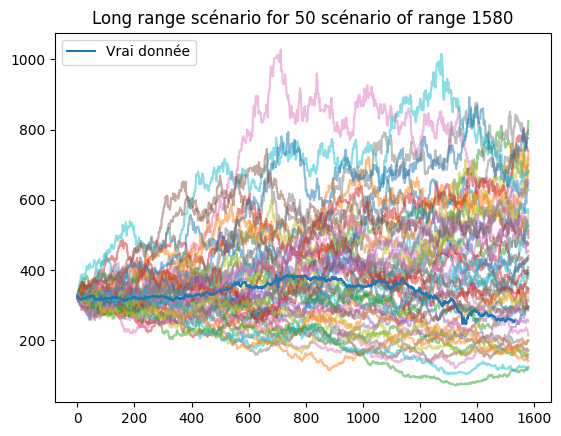

In [400]:
start = random.randint(500,2500)

v, fake_lines = generate_long_range(y[start:],true_y[start:],train_cnn,length=2000, n=50,reducer=1, show_real=True ,amplifier=1)

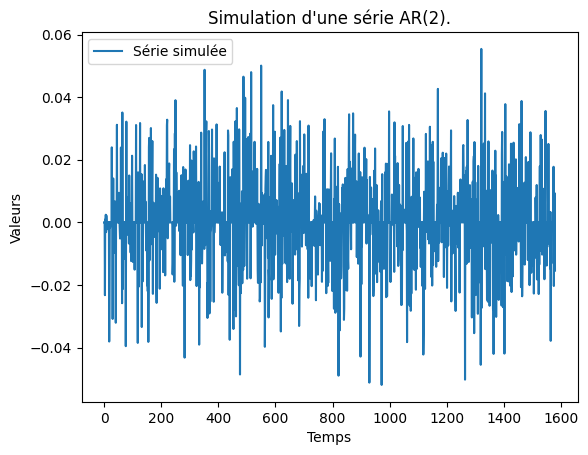

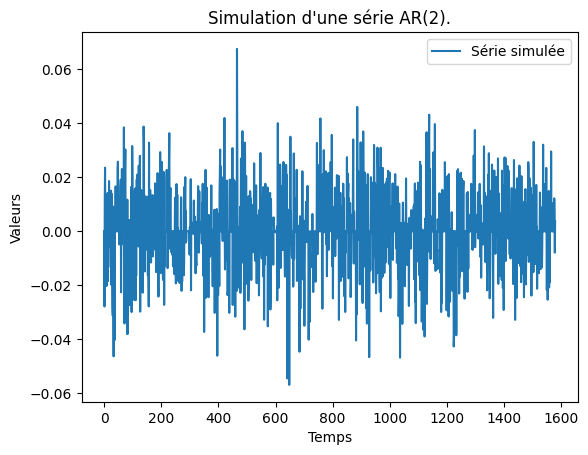

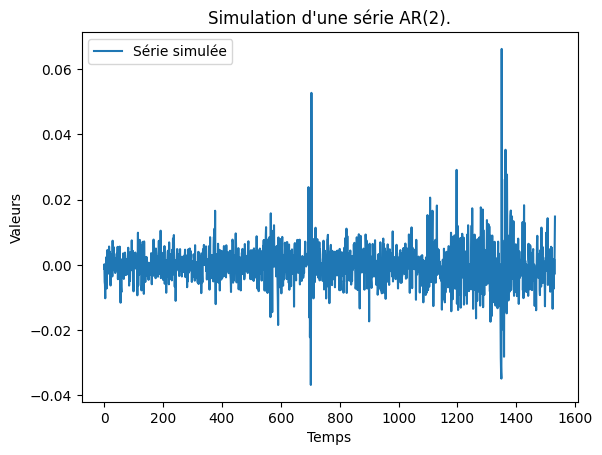

In [401]:
for i in range(2):
    x_hat = np.log(fake_lines[i,1:] / fake_lines[i,:-1])
    simple_plot(x_hat)
simple_plot(y[start:start+2000])

1078


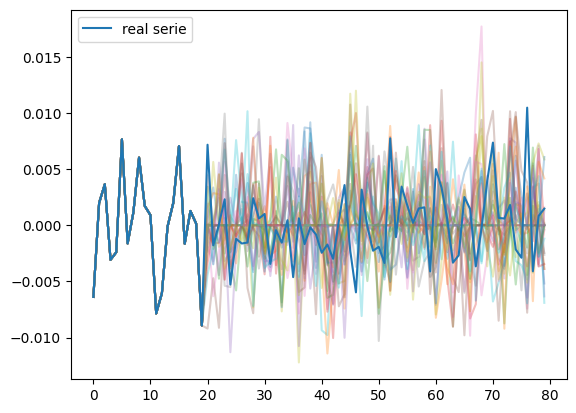

In [402]:
start = random.randint(200,2000)
num=30
amplifier = 1
noise = torch.randn((num, 1, train.latent_dim)) * amplifier
real_samples = torch.from_numpy(y[start:start+train.conditional])
noise[:, :, :train.conditional] = real_samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = noise.to(device)
v_lstm = train_lstm.G(noise) / 8
v = train.G(noise)/11
v_cnn = train_cnn.G(noise)/4
v[:, :, :train.conditional] = real_samples
v_cnn[:, :, :train.conditional] = real_samples
v_lstm[:, :, :train.conditional] = real_samples
v_lstm = np.array(v_lstm.float().cpu().detach()[:, 0,  :])
v = np.array(v.float().cpu().detach()[:, 0,  :])
v_cnn = np.array(v_cnn.float().cpu().detach()[:, 0,  :])
print(start)
for ar in v_cnn:
    plt.plot(ar, alpha=0.3)
plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
plt.legend()

In [403]:
v[0].shape

(80,)

In [404]:
v.shape

(30, 80)

1405


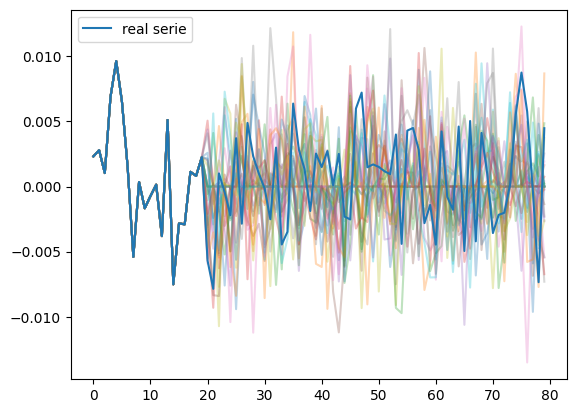

In [406]:
start = random.randint(200,2000)
num=30
amplifier = 1
noise = torch.randn((num, 1, train.latent_dim)) * amplifier
real_samples = torch.from_numpy(y[start:start+train.conditional])
noise[:, :, :train.conditional] = real_samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = noise.to(device)
v_lstm = train_lstm.G(noise) / 8
v = train.G(noise)/11
v_cnn = train_cnn.G(noise)/4
v[:, :, :train.conditional] = real_samples
v_cnn[:, :, :train.conditional] = real_samples
v_lstm[:, :, :train.conditional] = real_samples
v_lstm = np.array(v_lstm.float().cpu().detach()[:, 0,  :])
v = np.array(v.float().cpu().detach()[:, 0,  :])
v_cnn = np.array(v_cnn.float().cpu().detach()[:, 0,  :])
print(start)
for ar in v_cnn:
    plt.plot(ar, alpha=0.3)
plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
plt.legend()

374


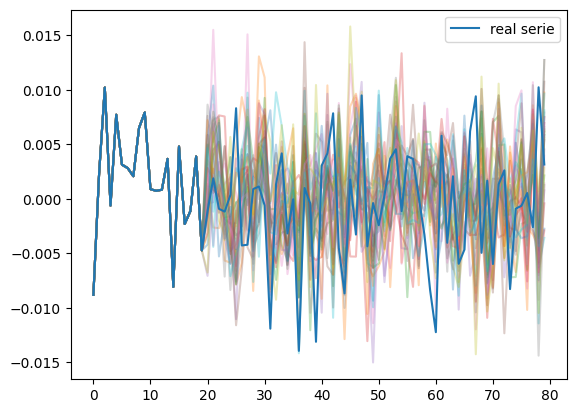

In [407]:
start = random.randint(200,2000)
num=30
amplifier = 1
noise = torch.randn((num, 1, train.latent_dim)) * amplifier
real_samples = torch.from_numpy(y[start:start+train.conditional])
noise[:, :, :train.conditional] = real_samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = noise.to(device)
v = train.G(noise) / 11
v[:, :, :train.conditional] = real_samples
v = np.array(v.float().cpu().detach()[:, 0,  :])
print(start)
for ar in v:
    plt.plot(ar, alpha=0.3)
plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
plt.legend()

In [409]:
help(show_generations)

Help on function show_generations in module __main__:

show_generations(num, train, amplifier=1, reducer=4, show_real=True, alpha=0.3, start=311)



406
406
406


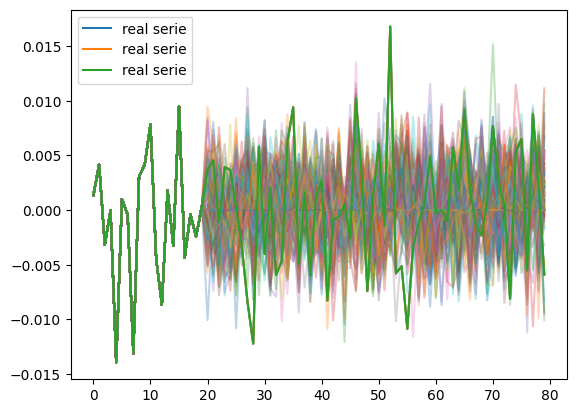

In [410]:
start = random.randint(200,2000)
v_base = show_generations(50, train,reducer=15, start=start)
v_lstm = show_generations(50, train_lstm,reducer=8, start=start)
v_cnn = show_generations(50, train_cnn,reducer=5, start=start)

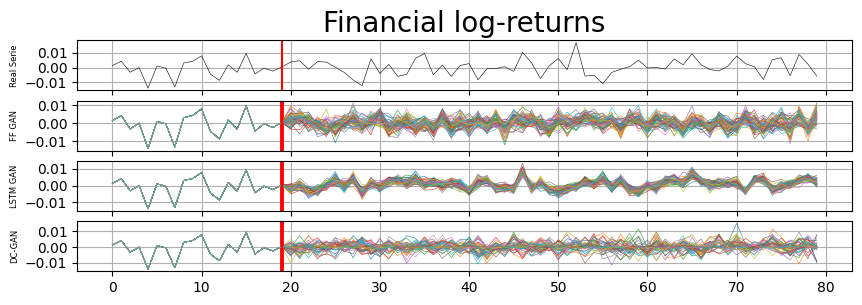

In [411]:
fig, axes = plt.subplots(4, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(y[start:start+train.ts_dim-train.conditional], lw=0.4, color="black")
axes[0].set_ylabel(f"Real Serie", fontsize=6)
axes[0].grid(True)
axes[0].axvline(x=train.conditional-1, color='red', linestyle='-')

for i, arr in enumerate(v_base, start=1):  
    axes[1].grid(True)
    axes[1].plot(arr, lw=0.4)
    axes[1].axvline(x=train.conditional-1, color='red', linestyle='-')

axes[1].set_ylabel(f"FF GAN", fontsize=6)
axes[1].yaxis.set_label_coords(-0.075, 0.5)

for i, arr in enumerate(v_lstm, start=1):
    axes[2].grid(True)
    axes[2].plot(arr, lw=0.4)
    axes[2].axvline(x=train.conditional-1, color='red', linestyle='-')

axes[2].set_ylabel(f"LSTM GAN", fontsize=6)
axes[2].yaxis.set_label_coords(-0.075, 0.5)

for i, arr in enumerate(v_cnn, start=1):
    axes[3].grid(True)
    axes[3].plot(arr, lw=0.4)
    axes[3].axvline(x=train.conditional-1, color='red', linestyle='-')

axes[3].set_ylabel(f"DC-GAN", fontsize=6)
axes[3].yaxis.set_label_coords(-0.075, 0.5)